In [121]:
import math

import jax
import scipy

jax.config.update("jax_enable_x64", True)
import diffrax
import numpy as np
from jax import numpy as jnp
from matplotlib.figure import Figure
from tqdm.notebook import tqdm, trange

%matplotlib inline

In [2]:
def f(t, y, θ):
    x, Dx = y
    return jnp.array([Dx, θ * (1 - x**2) * Dx - x])

In [3]:
t_0 = 0.0
t_1 = 20.0
y_0 = jnp.array([1.0, 1.0])
θ_0 = 2.0

CUDA backend failed to initialize: Unable to load cuPTI. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
def get_solution(θ):
    return diffrax.diffeqsolve(
        diffrax.ODETerm(f),
        y0=y_0,
        args=θ,
        t0=t_0,
        t1=t_1,
        dt0=1e-3,
        saveat=diffrax.SaveAt(dense=True),
        solver=diffrax.Kvaerno5(),
        stepsize_controller=diffrax.PIDController(
            rtol=1e-5, atol=1e-5, pcoeff=0.4, icoeff=0.3, dcoeff=0
        ),
        max_steps=10000,
    )

In [5]:
solution = get_solution(θ_0)

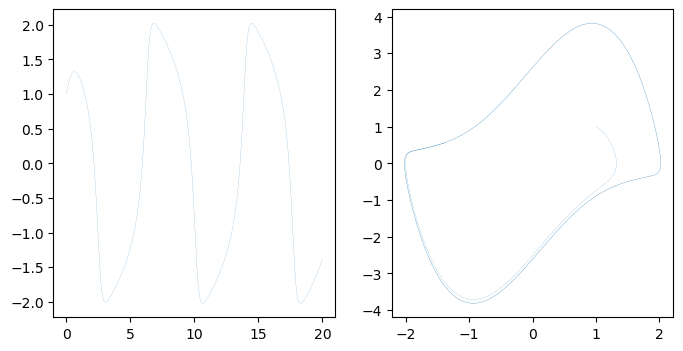

In [6]:
plot_ts = jnp.linspace(t_0, t_1, 10000)
plot_ys = jax.vmap(solution.evaluate)(plot_ts)

fig = Figure(figsize=(8, 4), dpi=100)
ax = fig.add_subplot(1, 2, 1)
ax.plot(plot_ts, plot_ys[:, 0], linewidth=0.1)
ax = fig.add_subplot(1, 2, 2)
ax.plot(plot_ys[:, 0], plot_ys[:, 1], linewidth=0.1)
fig

In [97]:
key = jax.random.PRNGKey(40)
data_ts = jnp.linspace(t_0, t_1, 1000)

In [128]:
def get_noisy_data(key):
    data_ys = jax.vmap(solution.evaluate)(data_ts)[:, 0]
    noise = jax.random.normal(key, shape=data_ys.shape)
    return data_ys + noise * 0.1

In [129]:
data_ys = get_noisy_data(key)

# likelihood method

In [130]:
def likelihood(key, θ):
    solution = get_solution(θ)
    return -jnp.sum((data_ys - jax.vmap(solution.evaluate)(data_ts)[:, 0]) ** 2)

In [131]:
θs = jnp.linspace(0.0, 50.0, 500)
likelihoods = jax.vmap(likelihood, in_axes=(None, 0))(key, θs)

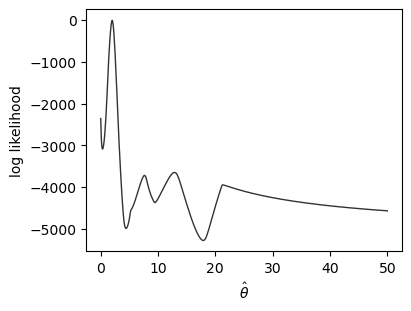

In [203]:
fig = Figure(figsize=(4, 3), dpi=100, constrained_layout=True)
ax = fig.gca()
ax.plot(θs, likelihoods, linewidth=1, color="black", alpha=0.8)
# ax.plot(θs, likelihoods_1, linewidth=0.7, color="black")
ax.set_xlabel(r"$\hat\theta$")
ax.set_ylabel("log likelihood")
fig.savefig("log-likelihood.pdf")
fig

# Differentiation method

In [133]:
d = 2
N = 100
t = jnp.linspace(0, t_1 * N / data_ts.shape[0], N)

In [134]:
def get_window_derivatives(data_ys, N):
    t = jnp.linspace(0, t_1 * N / data_ts.shape[0], N)
    vander = jnp.power(t.reshape(-1, 1), jnp.arange(d + 1))
    Q, _ = jnp.linalg.qr(vander, mode="reduced")
    unit_derivative = vander / jnp.array([math.factorial(k) for k in range(d + 1)])
    Q /= jnp.einsum("ik,ik->k", Q, unit_derivative)

    return data_ts[: -N + 1], jax.vmap(jnp.correlate, in_axes=(None, 1), out_axes=1)(
        data_ys, Q
    )

In [184]:
(key,) = jax.random.split(key, 1)
data_ys = get_noisy_data(key)
window_ts, window_derivs = get_window_derivatives(data_ys, 100)

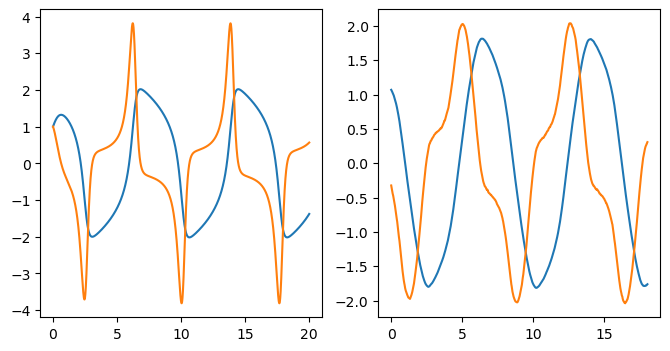

In [185]:
fig = Figure(figsize=(8, 4), dpi=100)
ax = fig.add_subplot(1, 2, 1)
ax.plot(plot_ts, plot_ys[:,], label=[0, 1])
ax = fig.add_subplot(1, 2, 2)
ax.plot(window_ts, window_derivs[:, :2])
fig

In [186]:
Φ_hat = jnp.vstack(
    [(1 - window_derivs[:, 0] ** 2) * window_derivs[:, 1], window_derivs[:, 0]]
).T

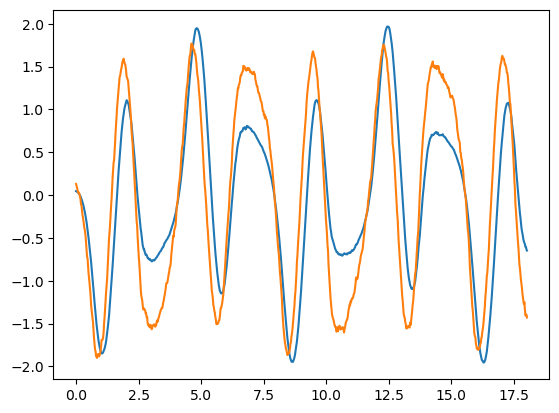

In [187]:
fig = Figure()
ax = fig.gca()
ax.plot(window_ts, Φ_hat[:, 0])
# ax.plot(window_ts, Φ_hat[:, 1])
ax.plot(window_ts, window_derivs[:, 2] + Φ_hat[:, 1])
# ax.legend()
fig

In [188]:
data_ys.shape

(1000,)

In [197]:
N = 50
λ = 1.0
num_trials = 1000
parameter_estimates = []
for _ in trange(num_trials):
    key, = jax.random.split(key, 1)
    data_ys = get_noisy_data(key)
    window_ts, window_derivs = get_window_derivatives(data_ys, N)
    Φ_hat = jnp.vstack(
        [(1 - window_derivs[:, 0] ** 2) * window_derivs[:, 1], window_derivs[:, 0]]
    ).T
    R_hat = jnp.vstack([λ * jnp.eye(2), Φ_hat])
    u_hat = jnp.vstack([jnp.zeros((2, 1)), window_derivs[:, 2].reshape(-1, 1)])
    coef, _, _, _ = jnp.linalg.lstsq(R_hat, u_hat)
    parameter_estimates.append(coef)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [198]:
parameter_estimates_array = np.array(parameter_estimates)

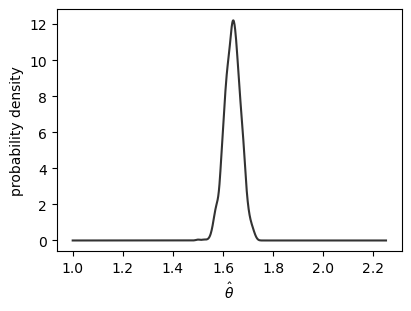

In [202]:
fig = Figure(figsize=(4, 3), dpi=100, constrained_layout=True)
ax = fig.gca()
kde = scipy.stats.gaussian_kde(dataset=parameter_estimates_array[:, 0].reshape(-1))
plot_θs = np.linspace(1, 2.25, 1000)
plot_dens = kde(plot_θs)
ax.plot(plot_θs, plot_dens, color='black', alpha=0.8)
ax.set_xlabel(r"$\hat\theta$")
ax.set_ylabel(r"probability density")
fig.savefig('sampling_estimator.pdf')
fig